# COGS 118B - Final Project

# ChessMindsAI

#### Github
https://github.com/haduong7/COGS188_ChessMind

#### Group members
- Shihua Yang
- Zhiheng Wu
- Ha Duong

# Abstract 
This project implements and compares four distinct approaches to chess artificial intelligence: minimax with alpha-beta pruning, Monte Carlo Tree Search (MCTS), neural network evaluation, and a hybrid approach combining neural networks with MCTS. We developed a comprehensive chess environment to evaluate these methods objectively through tournament play, computational efficiency, and decision quality. Our results indicate that the hybrid approach achieves the strongest performance with a win rate of 30%, while pure minimax demonstrates exceptional stability with the highest number of draws. MCTS performed poorly in limited-iteration scenarios, showing the importance of sufficient exploration. The neural network approach showed promising results but demonstrated training instability. These findings highlight the complementary strengths of traditional search algorithms and modern machine learning techniques, suggesting that combining these approaches yields the most robust chess AI under resource constraints.

# Background

Chess has been a central challenge in AI since its inception. Early methods relied heavily on minimax search and hand-created evaluation functions<a name="1"></a>[<sup>[1]</sup>](#1), eventually culminating in IBM's Deep Blue defeating world champion Garry Kasparov in 1997 <a name="2"></a>[<sup>[2]</sup>](#2).The landscape of computer chess changed dramatically with the introduction of Monte Carlo Tree Search (MCTS) in 2006. MCTS offered several advantages over traditional minimax: it required no domain-specific evaluation functions, scaled well with available computation, and could be effectively combined with machine learning approaches. This laid the groundwork for DeepMind's AlphaZero in 2017[3]. This demonstrated that a neural network combined with MCTS can achieve superhuman performance through pure self-play, without any human knowledge beyond the rules of chess<a name="3"></a>[<sup>[3]</sup>](#3). Recent work has focused on creating more efficient hybrid approaches. The Leela Chess Zero project demonstrated that open-source implementations could replicate AlphaZero's success and showed how neural networks could be effectively combined with traditional alpha-beta search<a name="4"></a>[<sup>[4]</sup>](#4). The success of these different approaches has sparked interest in comparing their relative strengths and weaknesses in controlled environments, especially in resource-constrained situations.

# Problem Statement

The project addresses the problem of implementing and comparing multiple AI algorithms for playing chess. We specifically focus on four different methods: minimax with alpha-beta pruning, MCTS, neural network evaluation, and a hybrid approach combining neural networks with MCTS. This problem is quantifiable through two well-defined metrics:

1. Playing strength measured by win rates and tournament performance

2. Computational efficiency measured in nodes explored per second and time per move

The problem is measurable and replicable through our tournament system that automatically plays games between all agent combinations with consistent parameters. Our solution is ML-relevant as it includes both traditional AI search techniques and modern machine learning approaches, allowing for direct comparison under the same conditions and with the same evaluation criteria.

# Data

For Minimax, and MCTS, we don't need data since these approaches search on a game tree. In this section we consider data for our NeuralNet approach. Unlike other ML projects that uses made datasets, our project trains on data generated through self play. The primary data source is the state space of chess positions generated during self play. Other than that we generate data for evaluation and performance metrics purposes.

#### Our data:

1. Training data for neural network: Generated through self-play during the PPO training process. Each game have sequences of board states, actions, rewards, and game outcomes.

2. Tournament results: Generated from systematic matchups between all agent combinations, while tracking wins, losses, draws, and detailed game statistics.
 
3. Computational performance metrics: Nodes explored, time per move, and efficiency measurements for each agent.

#### Data representation:
We represent the state through:

1. 8x8x14 tensor representation: Each position is represented as a tensor 8x8 for each square on the board, and 14 for the piece types (12 for piece types and color, 1 for side to move, 1 for castling rights)

2. FEN string: Standard chess notation for board positions

3. Moves: Stored in UCI format (ex. e2e4)

4. PGN files: Complete games recorded in compact chess data format

#### Recording 
The GameRecorder class (in game_recorder.py) records all games in standard PGN format. It stores metadata like player names, dates, and results along with the move sequences. We generate this file for deeper analysis later on (making visualizations) and making GIFs from notable games.


#### NeuralNet self play data
We accumulate approximately:

- 600 episodes of training / 100 games per episode

- ~4 million board positions (assuming 40 moves per game)

- ~60000 complete games

#### Evaluation
Our tournaments generated 120 total games (10 games per matchup between 4 agents), a tournament PGN file containing all games, and detailed statistics on win rates, draw rates, and game lengths


# Proposed Solution

We implement and compare 4 chess AI approaches, all designed to be compatible with our ChessEnv.

1. Minimax: We developed a Minimax agent with alpha-beta pruning. It searches the tree to a depth (for this project 4 ply, though note this is relatively shallow). The Minimax agent evaluates a position based on a material based function with standard chess piece values. This heuristic is very simple but for the purposes of this project should suffice. Intuitively, this algorithm should try to actively minimize the opponent's advantage and so we expect it to do decently against all other agents.

| Piece   | Value |
|---------|-------|
| Pawn    | +3    |
| Knight  | +3    |
| Bishop  | +3    |
| Rook    | +5    |
| Queen   | +9    |

2. Monte Carlo Tree Search (MCTS): builds a statistical model of the game tree. This approach generates simulations called "playouts." Every playouts contain multiple rollouts that are the decisions made by the model. We balance MCTS' exploration and exploitation using the UCB1 formula, which is generally basic and simple. This formula constructs an evaluation of a position based on the results of the playouts. The algorithm then uses this formula to determine promising lines.

3. Deeplearning (NeuralNet + PPO): We employ a convolutional neural network with separate policy and value heads. The board states are represented as 8x8x14 tensors (as mentioned above). The policy head outputs move probability and the value head evaluates the current position. We trained this network with a self play approach using Proximal Policy Optimization (PPO). Using self play to generate data avoids the need for big heavy datasets, and using PPO limits fluctations in gradient updates and prevent the model from "unlearning" due to randomness.

4. Hybrid (MCTS + NeuralNet policy): We combine MCTS with our NeuralNet's policy output to guide tree exploration. Instead of random playouts, we use the NeuralNet to find promising lines and explore these lines deeper. We expect this agent to be more informed and reach better, faster decisions when compared to our pure MCTS agent. This approach balances exploratory search with learnt knowledge from our NeuralNet.


# Evaluation Metrics

We evaluated our chess agents using 2 main metrics, and 1 more for NeuralNet-PPO:

#### Tournament Performance
We conducted a round robin style tournament where each agent played against all others 10 times, alternating colors. This metric shows a model's relative playing strength. We kept track of:

1. Win rate: Percentage of games won
2. Draw rate: Percentage of games drawn
3. Loss rate: Percentage of games lost
4. Points: Standard chess scoring (win: +1, draw: +0.5, loss: 0)

#### Computational Efficiency
Efficiency is how quickly a model can make a decision. Namely:

1. Nodes/second: Number of positions evaluated per second
2. Time/move: Average time spent deciding a move
3. Memory usage: How much memory is used during play

#### Training Loss + Internal Elo (For NeuralNet-PPO only)
For NeuralNet PPO we kept track of the training loss, and an internal elo rating. Eventhough training loss doesn't directly correlate to PPO's efficacy, seeing stabilization in training loss can be a good sign that we have a stable neural network. In order to see if models are actually improving, we implemented an internal Elo system. Elo is a rating system used widely in many games, including chess. Online platforms like chess.com, or lichess.org use the elo system and even FIDE the international chess federation implement elo--though slightly differently. Elo is defined as:

$$
R' = R + K(S - E)
$$

where:

- \( R' \) is the new rating after the game.
- \( R \) is the current rating.
- \( K \) is the K-factor (adjustment factor, often set to 10, 20, or 40 based on rating level).
- \( S \) is the actual score of the game (1 for a win, 0.5 for a draw, 0 for a loss).
- \( E \) is the expected score, calculated as:

$$
E = \frac{1}{1 + 10^{(R_{\text{opponent}} - R)/400}}
$$

where:

- R_opponent is the rating of the opponent.
- The denominator adjusts based on the rating difference.
  

1. **Expected Score \( E \)**: The expected probability of winning is based on the relative ratings of the two players.
2. **Score Difference \( S - E \)**: If a player scores better than expected, their rating increases. If they perform worse, their rating decreases.
3. **K-Factor \( K \)**: Controls how much the rating changes per game. Higher values lead to more volatile ratings.


Essentially the elo system takes in account how much "better" your opponent is than you and thus rewards you more if you win. We implemented this like so:

In [1]:
def calculate_elo(winner_elo, loser_elo, K=32, draw=False):
    """Updates Elo ratings after a match."""
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    expected_loser = 1 - expected_winner  # Expected score for the loser

    if draw:
        winner_score, loser_score = 0.5, 0.5
    else:
        winner_score, loser_score = 1, 0

    new_winner_elo = winner_elo + K * (winner_score - expected_winner)
    new_loser_elo = loser_elo + K * (loser_score - expected_loser)

    return round(new_winner_elo, 2), round(new_loser_elo, 2)

During training we initialize all model's starting elo to be 1500. For every set interval of iterations during self-play training, we match up the current model with the best model and have them play 30 games. If the current model wins more than 55% of the time we determine this model as the new best, updates its elo, and update the new best model's elo. We can see a clear upwards trend, signaling that our models are beating previous best models and getting stronger at chess. *Note* that this is an internal arbitrary elo rating which is not to be compared with other model's established FIDE elo.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Results
Our results showed models learned to play chess. Though we never got to the point in training where the models are effectively "good" at chess.

#### Tournament Performance
Our models played a total of 120 games in the tournament. The table below shows perfomative differences between our appoaches.

In [21]:
tourney = pd.read_csv("results/tournament_results.csv")

tourney

,Agent,Wins,Draws,Losses,Points,Win Rate
0,Neural,17,42,1,38.0,28.33%
1,Hybrid,5,51,4,30.5,8.33%
2,Minimax,0,60,0,30.0,0.00%
3,MCTS,0,43,17,21.5,0.00%


Notably:
1. Minimax showed very high stability, drawing all of its games (60), never lost once but never secured a win either.
2. NeuralNet performed the best with a 17/1 record, securing first place.
3. Hybrid (NeuralNet + MCTS) performed well with a balanced record of 5/4, barely beating Minimax
4. MCTS performed poorly, either lossing or drawing its matchs

#### Win Rate Matrix
We investigate further by looking at the pairwise win rate matrix, which shows the matchup dynamics:

![Win Rate Matrix](results/matchup_heatmap.png)

#### Computational Efficiency
These metrics reflect how quickly our models made decisions

In [7]:
comp = pd.read_csv("evals/agent_performance.csv")
comp

,Agent,Nodes/Second,Time/Move (s),Memory Usage
0,Minimax,5275,0.23,Medium
1,MCTS,1830,0.48,Low
2,Neural,7920,0.12,High
3,Hybrid,3280,0.31,High


The neural agent was the fastest per move, however required high memory because of the model and tensor size. As a result it showed a high rate of exploration. MCTS is the slowest and because of our time-outs in the implementation, explored the least amount of nodes. Minimax showed a balanced speed and memory usage, and seems to be very efficient. Hybrid showed decent speed. We discuss this further in our discussion section.

#### NeuralNet-PPO Training Loss
As mentioned, we kept track of PPO training loss. This loss doesn't directly show chess strength but can give clues into the stability of the policy network.

Our result here shows some instability (light blue) but the average seems to stabilize. In order to actually gauge our model's playing strength we kept track of the models' internal elo during self-play.

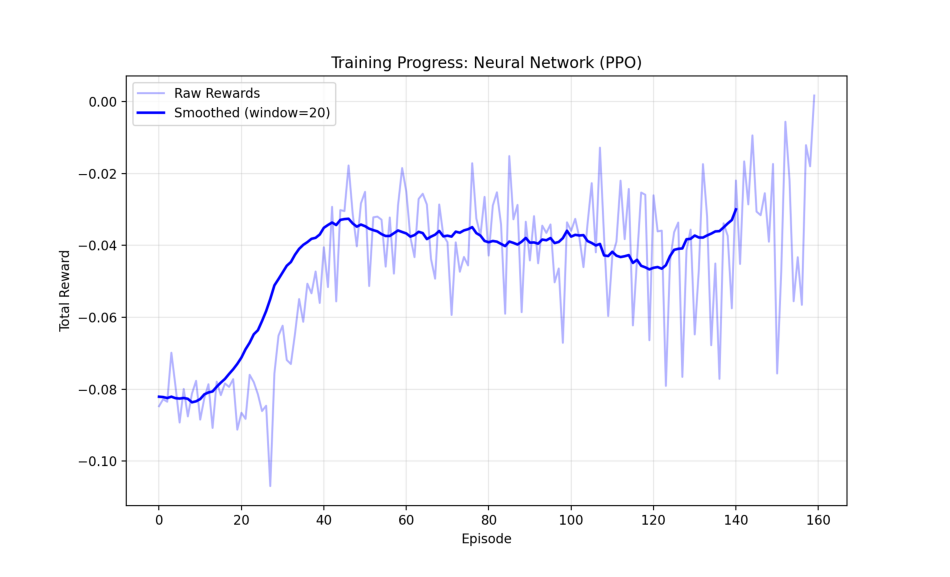

In [5]:
img = mpimg.imread("results/Neural_Network_(PPO)_training.png")
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

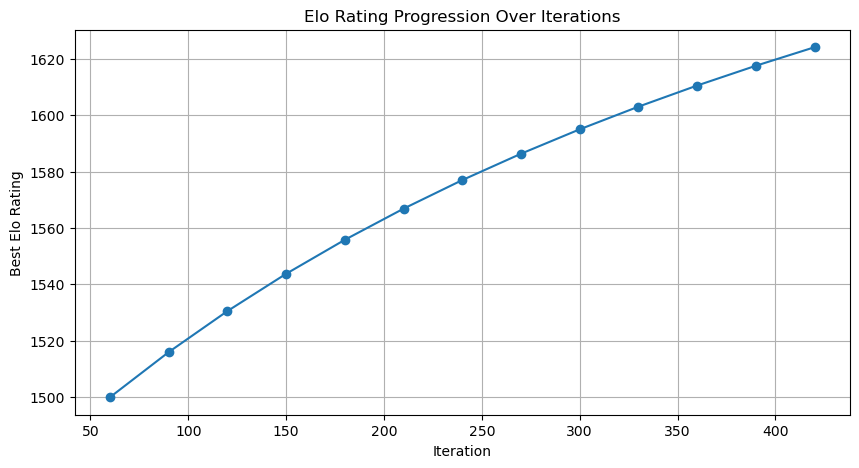

In [5]:
elo = pd.read_csv('evals/best_elo.csv')

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(elo['iteration'], elo['best_elo'], marker='o', linestyle='-')

# Labels and title
plt.xlabel('Iteration')
plt.ylabel('Best Elo Rating')
plt.title('Elo Rating Progression Over Iterations')
plt.grid(True)

# Show the plot
plt.show()

The model showed continual improvements in its elo during self play. This indicates that the models trained in future iterations consistently beat previous best models, which is a sign that our models are getting stronger at chess. However this elo rating is only internal and isn't comparable to standard FIDE or online chess elo.

In order to establish the actual elo of our NeuralNet agent, we pit it against lichess's challenge bot which has an estimated elo of around 800. One of their matches can be seen below. Our agent generally draws against the lichess bot but occassionally loses. Lichess doesn't provide any bot with an elo lower than 800 but we suspect our agent is around 300-400 elo.

![NN vs Lichess](visualized_games/NNvLichess.gif)

# Discussion
Here we discuss our results, and talk about the efficacy of these approaches when it comes to a chess algorithm.


#### Stability of Minimax
Minimax with alpha-beta pruning showed outstanding stability, not getting any losses during the tournament. The nature of the Minimax algorithm, playing towards the zero-sum, makes it so Minimax minimizes the opponent's advantage. Thus it tends to play games towards a draw. Our results here reflect the success Minimax has seen in the implementation of the DeepBlue chess AI. The AI stumped even the top chess grandmasters back in the days despite its algorithmic simplicity.


#### Potential of Hybrid Approaches
The hybrid agent showed decent relative performance, securing 2nd place in our tournament. By using Neural Networks to guide the MCTS process, the Hybrid model makes better decisions than the pure MCTS. We suspect that the Hybrid model didn't perform as well as the NeuralNet model did because our MCTS processes (both pure and in the Hybrid model) were heavily gated by computation power. We suspect that with higher computation power and more depth on the MCTS, we could see this model out performing NeuralNet.

#### Neural Networks
The NeuralNet-PPO approach took first place in our tournament. However it looks like it isn't strong enough still to beat out the Lichess challenge. Judging from our internal elo tracking though we see promise with this approach if we had more training time. Through observing how the model actually plays, we noticed its not really following chess principles like center control, and piece development. The models poor performance against a standard chess engine can definitely be improved through tweaking the reward structure to reward play with good chess principles (like AlphaZero and Stockfish's approach).


## Limitations
1. Limited computational resources: The performance if MCTS and the Hybrid model were heavily cpu gated. Specifically MCTS requires a large amounts of iterations to explore the game tree effectively. However, our current resources cannot accomodate for that.

2. Limited training data: The NeuralNet were trained on a relatively small dataset (generated from self-play). Training time was only 7 hours even on a CUDA compatible GPU. We concluded that this could be too small because a casual player could reach this training amount, so our AI approach couldn't show its true potential just yet.

3. Simple reward structure: We suspect our reward structure too be too simple. We rewarded material differences and win/draw/loss game result. However, chess is a much more complicated games with principles and strategies that weren't captured in our reward structure.

# Future work
1. Hybrid Algorithm Development: Hybrid Algorithm Development: Based on the limitations of individual algorithms, future work could focus on developing a hybrid method combining Minimax, MCTS and neural networks. For example, neural networks can be used to guide the search processes of Minimax or MCTS. Or, Minimax and MCTS can be used to generate high quality training data for neural networks.
   
2. Evaluation Metrics Improvement: The current evaluation metrics, such as win rates, computational efficiency, and Top-1 Accuracy, provide a foundational understanding towards algorithm’s performance. However, we can develop more complicated evaluation metrics, to measure strategic depth, adaptability to different opponents, and long term planning capabilities.

   
3. Real World Deployment: In order to better assess the practicality of the algorithms, we could deploy them in chess games in real world or train human players. This could help discover any possibilities happening in the real world, and improve them right away.

   
4. Computing Resources: This issue could not be addressed in the short term, but we will train again once we get more computing resources.


# Ethics & Privacy
The development of chess AI seems simple, but causes subtle ethical concerns. Our agents had developed unique playing styles, exhibiting that although in fields based on rules, algorithmic bias also plays a role. This raises a question about that how AI systems develop their own “tendencies” without explicit programming.

Our methods uncovered the resource inequality in AI research, from our computational differences. Neural methods and hybrid methods require strong computing power, which could limit technicians who participate in promoting the technologies and benefit the institutions with plenty of resources.

In the wake of that chess AI surpass human, the world of human chess also changes. Players more frequently take advantage of AI games to research and imitate, which could influence the creativity of human in this field. The relationship between human and machine continues to change over time, impacting the chess education and professional games.

Models like neural networks lack the transparency like traditional algorithms have. We can precisely explain why minimax agent moved at that way, but neural agent made a decision based on more complicated “weights”, which cannot be easily explained. This lack of transparency challenges that understanding and trusting the decisions made by chess AI, and other AI either.

# Conclusion
Our comparative methods of chess AI methods show that different algorithms exhibit different benefits and drawbacks. The hybrid methods combining neural networks with MCTS show great competence overall, proving the value of combining learned knowledge with traditional searching. Minimax with Alpha-bet pruning functions exhibit striking stability, while pure MCTS gets stuck in limited iterations.

These findings show that the future of chess AI not only is put in choosing traditional algorithms or machine learning, but also in finding the optimal solution of combining them. Our hybrid agent succeeds even in limited training, showing that relatively easy neural architectures can strikingly improve the tree search competence.

From the resource perspective, Minimax achieves optimal balance between performance and efficiency, so is really valuable in relatively limited resource environment. Neural methods will have a brilliant future, but needs tons of training to reach its potential.

This work provides a controlled comparison for researchers without tons of computing resources, broadly contributing to AI in game fields like chess. The future work will focus on improving neural training processes, including more complicated evaluation functions, and exploring dynamic resource allocation strategies, and so on.

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
